# V3 Galaxy ML testing
This notebook uses an enhanced dataset with features from the full 2MRS catalog and the t5 table of the Tully 2015 paper.




In [ ]:
#Imports
import scipy
import pandas as pd
import numpy as np
import sklearn
from pandas import read_csv
from matplotlib import pyplot as plt
import seaborn as sns
import os
from google.colab import drive

#Model-assisting import
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Model imports

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Physics Research/Fall 2024 Research')

In [ ]:
overlap_t5_file = read_csv('overlap_t5_file.csv')
overlap_t5_file.head()

In [ ]:
# Handling outliers using IQR Method

# Calculate IQR for SDSS
Q1_sdss = overlap_t5_file['SDSS Local Density'].quantile(0.25)
Q3_sdss = overlap_t5_file['SDSS Local Density'].quantile(0.75)
IQR_sdss = Q3_sdss - Q1_sdss

# Determine outlier thresholds
# A smaller multiplier than 1.5 would identify more outliers and vice versa
lower_bound_sdss = Q1_sdss - 1.5 * IQR_sdss
upper_bound_sdss = Q3_sdss + 1.5 * IQR_sdss

# Calculate IQR for 2MRS
Q1_2mrs = overlap_t5_file['2MRS Local Density'].quantile(0.25)
Q3_2mrs = overlap_t5_file['2MRS Local Density'].quantile(0.75)
IQR_2mrs = Q3_2mrs - Q1_2mrs

# Determine outlier thresholds
# A smaller multiplier than 1.5 would identify more outliers and vice versa
lower_bound_2mrs = Q1_2mrs - 1.5 * IQR_2mrs
upper_bound_2mrs = Q3_2mrs + 1.5 * IQR_2mrs

# Identify SDSS outliers
outliers_iqr_sdss = overlap_t5_file[(overlap_t5_file['SDSS Local Density'] < lower_bound_sdss) |
                           (overlap_t5_file['SDSS Local Density'] > upper_bound_sdss)]
print(f'SDSS Outliers Shape: {outliers_iqr_sdss.shape}')

# Identify 2MRS outliers
outliers_iqr_2mrs = overlap_t5_file[(overlap_t5_file['2MRS Local Density'] < lower_bound_2mrs) |
                           (overlap_t5_file['2MRS Local Density'] > upper_bound_2mrs)]
print(f'2MRS Outliers Shape: {outliers_iqr_2mrs.shape}')

# Creating the pruned data based on both local desnity features
pruned_overlap  = overlap_t5_file[(overlap_t5_file['SDSS Local Density'] >= lower_bound_sdss) &
                                (overlap_t5_file['SDSS Local Density'] <= upper_bound_sdss) &
                                (overlap_t5_file['2MRS Local Density'] >= lower_bound_2mrs) &
                                (overlap_t5_file['2MRS Local Density'] <= upper_bound_2mrs)]

print(f'Pruned Dataset Shape: {pruned_overlap.shape}')

SDSS Outliers Shape: (467, 18)
2MRS Outliers Shape: (445, 18)
Pruned Dataset Shape: (2401, 18)


In [ ]:
vals = pruned_overlap.values
mrs_dens_col = vals[:, 3]
print(mrs_dens_col[0:10])

[0.06105948 0.00582575 0.01192735 0.13774581 0.01762082 0.0594505
 0.03896218 0.03957731 0.00361875 0.06969818]


In [ ]:
# Creating the splits

sdss_dens_col = pruned_overlap.pop('SDSS Local Density')
pruned_overlap['SDSS Local Density'] = sdss_dens_col

vals = pruned_overlap.values

log_data = np.copy(vals)
log_data[:, 3] = np.log(vals[:, 3])  # Transforms 2MRS Local Density values
log_data[:, -1] = np.log(vals[:, -1])  # Transform SDSS Local Density values

X = log_data[:, 0:-1] # All columns except SDSS Local Density
y = log_data[:, -1] # SDSS Local Density (logged)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

<ipython-input-16-5707aac6ef33>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruned_overlap['SDSS Local Density'] = sdss_dens_col


In [ ]:
# Normalizing the data

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()

# Fit and transform the data
scaler.fit(X_train)
X_train_sscaled = scaler.transform(X_train)
X_test_sscaled = scaler.transform(X_test)

In [ ]:
# K-Fold Cross-Validation To Compare Models

# Initialize the models
models = []
models.append(('LR', LinearRegression()))
models.append(('RFR', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=5))) #default k is 5
models.append(('GBR', GradientBoostingRegressor()))
models.append(('SVM', SVR(gamma='auto')))

print('Model RMSEs:\n')
for name, model in models:
  kfold = KFold(n_splits=5, random_state=15, shuffle=True)
  cvResult = cross_val_score(model, X_train_sscaled, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
  print(f'{name}: {round(-cvResult.mean(), 2)}')

print('\nModel R^2s:\n')
for name, model in models:
  kfold = KFold(n_splits=5, random_state=15, shuffle=True)
  cvResult = cross_val_score(model, X_train_sscaled, y_train, cv=kfold, scoring='r2')
  print(f'{name}: {round(cvResult.mean(), 2)}')

Model RMSEs:

LR: 1.13
RFR: 1.01
KNN: 1.2
GBR: 1.04
SVM: 1.09

Model R^2s:

LR: 0.38
RFR: 0.5
KNN: 0.3
GBR: 0.47
SVM: 0.42


In [ ]:
# Predicting with RFR
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train_sscaled, y_train)
predictions = model_rfr.predict(X_test_sscaled)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(y_test, predictions)}\n')
print(f'R^2 Score: {r2_score(y_test, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(y_test, predictions), 2)}%\n')

Root Mean Squared Error: 1.0304250785652287

R^2 Score: 0.5198440115481278

MAPE Score: 1.92%



Importances: [0.04939812 0.04931769 0.07980393 0.09122151 0.0195527  0.0205499
 0.02012279 0.02482166 0.02173531 0.02432481 0.03062133 0.03173721
 0.03079764 0.1508838  0.03033496 0.03732302 0.28745362]


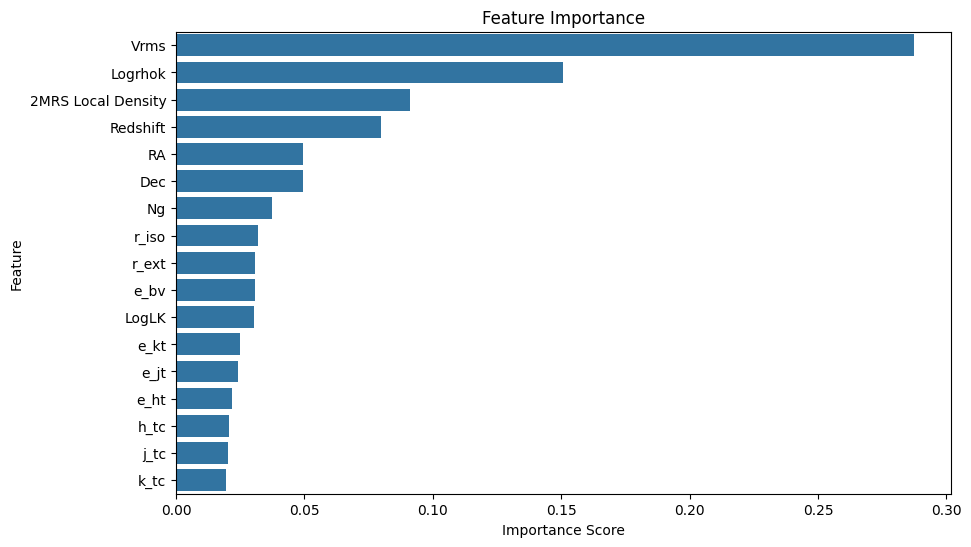

In [ ]:
import seaborn as sns

# Extract feature importances
importances = model_rfr.feature_importances_

print(f'Importances: {importances}')

col_names = pruned_overlap.columns.tolist()

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': col_names[:-1],
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()